# Background sculpting

**Goal:** Run the GNN that I trained on 2b events as well.

I want to see:
1. If the massplane distribution is as sculpted
2. Get the corresponding *cutflow* for the background and compare w/ the cutflow that I would have gotten for the baseline analysis, but separately for the 3b and 4b categories (is this ok, or would Max get mad at me for "unblinding"... maybe it's ok if I look at events that are *not* inside the SR)
3. Derive the background estimate
4. Make categories, and compare the significances in each of the bins
5. Get (stats only) limits

Ok, so since I have a steering script that lets me process and concatenate the data from individual periods, I think I might want to go with a version of the notebook that runs with Rafael's conda env for the keras background reweighting.

`source /gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/bin/activate py3`

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

import os
os.sys.path.append('../code')
from analysis import *

%load_ext autoreload
%autoreload 2

This step just shows how many files from my analysis.py script are in each period.

In [2]:
reload = False
nSelectedJets = 5

subDir = 'data_16_PFlow-MAY2019'
if nSelectedJets != 4:
    subDir += f'-{nSelectedJets}jets'
    
trigger ='2016_triggers'

fDir = f"../data/{subDir}/"

In [3]:
fDir = f"../data/{subDir}/"
periods = ['A','B','C','D','E','F','G','H','I','J','K','L']

for period in periods:

    fName = f"files/df_period{period}_f_0.22_00*_entry_*00.h5"
    i = len(glob(fDir+fName))
    print("period",period,":",i)

period A : 20
period B : 18
period C : 26
period D : 43
period E : 11
period F : 22
period G : 29
period H : 0
period I : 35
period J : 0
period K : 15
period L : 56


## 1. 2b massplane

In [12]:
# cols = ['m4j','nbtags','Xwt','deta_hh',
#         'HC1_m','HC2_m','HC1_pt','HC2_pt','HC1_dRjj','HC2_dRjj',
#         # Booleans for the cuts n the analysis
#         'MDR','MDpT','SR','CR','SB',
#         # rw cols
#         'njets','pT_2','pT_4','eta_i','dRjj_1','dRjj_2','pt_hh']

#nbtags = -1


In [13]:
'''
I've decided it's faster to execute this block using the ../steerProcessData.py script
'''

# if reload:
#     for period in periods:

#         print('period',period)
#         fName = f"files/df_period{period}_f_0.22_00*entry_*000.h5"

#         dfs = []
#         for myFile in tqdm(glob(fDir + fName)):
#             dfi = pairAndProcess(myFile,nbtags,region, cols=cols)
#             if dfi is not None:
#                 dfs.append(dfi)

#         if len(dfs) > 0:
#             df = pd.concat(dfs,ignore_index=True)
#             fout = f"{fDir}files/df_period{period}_f_0.22_fullmassplane.h5"
#             df.to_hdf(fout,key='df',mode='w')

"\nI've decided it's faster to execute this block using the ../steerProcessData.py script\n"

Next loop over the periods and concatenate

In [9]:
tag = '_NNT_HCs'
fout = f"{fDir}df_f_0.22{tag}.h5"

if reload:
    dfs = []

    for period in periods:

        print('period',period)
        fName = f"files/df_period{period}_f_0.22{tag}.h5"

        if os.path.exists(fDir+fName):
            dfi = pd.read_hdf(fDir+fName,key='df')
            print(dfi.columns)
            dfs.append(dfi)
        else:
            print(fDir+fName)

    df = pd.concat(dfs,ignore_index=True)
    df.to_hdf(fout,key='df',mode='w')
    
else:
    df = pd.read_hdf(fout,key='df')

In [15]:
from preprocess import MDR_cut

In [16]:
MDR_mask = MDR_cut(df.dRjj_h1,df.dRjj_h2,df.m_hh)
df['MDR'] = MDR_mask

In [17]:
df['lead_HC_pt'] = np.where(df.pT_h1>df.pT_h2, df.pT_h1, df.pT_h2)
df['subl_HC_pt'] = np.where(df.pT_h1>df.pT_h2, df.pT_h2, df.pT_h1)

In [18]:
lead_pT_cut = 0.5  * df.m_hh - 103
subl_pT_cut = 0.33 * df.m_hh -  73
df['MDpT'] = (df.lead_HC_pt > lead_pT_cut) & (df.lead_HC_pt > subl_pT_cut) & df['MDR']

In [10]:
df['deta_hh'] = np.abs(df.eta_h1-df.eta_h2)

In [20]:
# Apply the cuts up to Xwt
df['cut_deta_hh'] = (df.deta_hh < 1.5) & (df.MDpT)
df['cut_Xwt'] = (df.X_wt > 1.5) & (df.cut_deta_hh)

Ok - the first time I ran this notebook, I didn't save the SR, CR, and SB, but with the HCs, I should be able to recalculate them pretty straightforwardly rn.

In [21]:
df.head()

run_number  event_number  mc_sf  ntag  njets  kinematic_region        m_hh  \
0      298609       4238123      1     3    4.0                -1  813.706916   
1      298609       3840953      1     3    6.0                -1  310.964570   
2      298609       3558172      1     1    4.0                -1  535.070163   
3      298609       5425711      1     2    4.0                 2  385.289116   
4      298609       6145057      1     3    6.0                -1  714.077979   

        pt_hh      X_wt    m_hh_cor  ...       Phi      Phi1          HT  \
0   20.928099  6.691344  948.862363  ... -1.110465 -1.667462  727.469765   
1   99.894391  2.994519  428.502949  ... -0.231398  1.167814  256.998151   
2  127.016966  2.561435  491.570482  ...  1.463708 -1.535119  256.569325   
3   17.175302  3.725297  365.228218  ... -1.427715 -2.454804  308.010071   
4  117.401132  4.495913  640.855832  ... -0.206904  1.868478  284.632328   

     MDR   MDpT  cut_deta_hh  cut_Xwt  lead_HC_pt  subl_HC_pt   deta_hh  
0   True   True         True     True  367.617581  349.633026  0.760314  
1   True   True        False    False  126.795814   32.551788  2.558353  
2  False  False        False    False  129.130292    3.321973  6.189779  
3   True   True         True     True  131.905499  118.727856  0.622442  
4  False  False        False    False  134.746224  101.684031  2.966884  

[5 rows x 38 columns]

Note for future self: If I put the HC formation w/ the GNN inside `preprocess.py`, I could get the cutflow #s in this block as well.

Look at the massplane before applying the rest of the analysis selection. (Note: It would also be nice maybe to compare to the baseline at this point, maybe with some metrics for the smoothness as well, such as the moments of the distributions?)

Maybe I could use Lucas's really nice massplane script?

**Next:** Let's make this same plot with [Lucas's massplane fucntion](https://gitlab.cern.ch/lborgna/eda_tools/blob/master/plot_helper.py#190-278)

In [3]:
os.sys.path.append('../eda_tools')
from plot_helper import massplane

In [4]:
subDir

'data_16_PFlow-MAY2019-5jets'

In [5]:
figDir = f'figures/{subDir}/xformer_train_SMNR_mc16ade/'

In [15]:
kwargs = {'figsize': (10, 8),
           'bins' : (125, 125),
           'xrange': (25, 275),
           'yrange': (25, 275),
           'xhisttype': 'step',
           'yhisttype': 'step',
           'cmap': 'YlGnBu',
           'title': 'pairAGraph: just pairing',
           'xlabel': '$m_{HC1}$ [GeV]',
           'ylabel': '$m_{HC2}$ [GeV]',
           'axis_hist_on': True,
           'hist_color': 'black',
           'filename': f'{figDir}/massplane_4jetsGNN_2b.pdf',
           'alpha': 0.7,
           'save': True,
           'show': True
          }

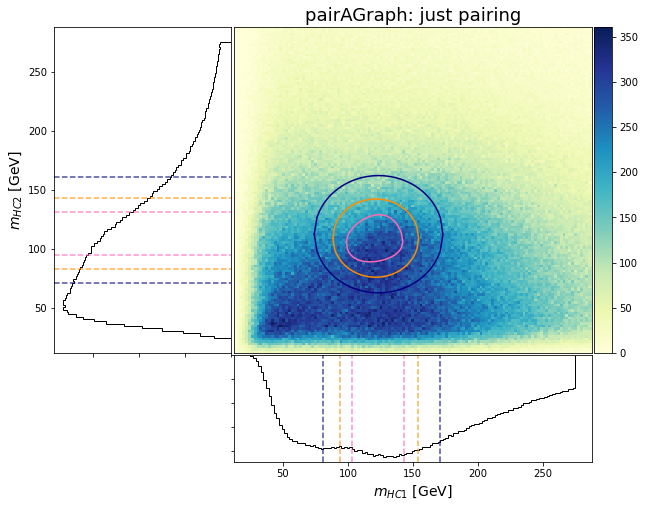

In [14]:
fig = massplane(df.loc[df.ntag==2,'m_h1'],
                df.loc[df.ntag==2,'m_h2'],**kwargs)

fig.show()

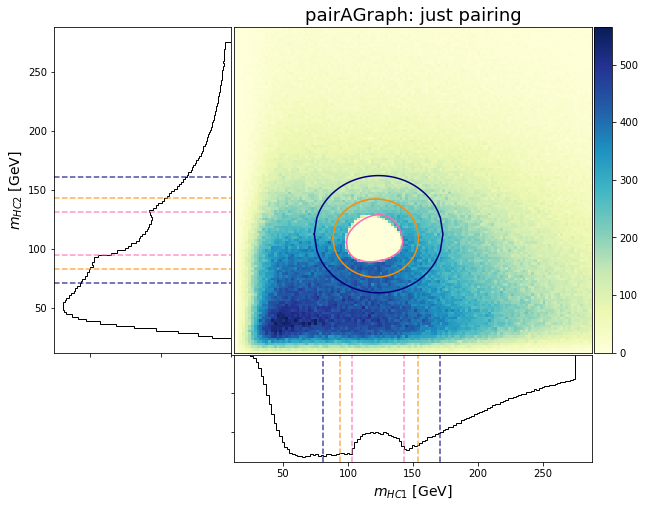

In [27]:
kwargs['filename'] = f'{figDir}/massplane_4jetsGNN_3b.pdf'

fig = massplane(df.loc[(df.ntag==3) & (df.kinematic_region != 0),'m_h1'],
                df.loc[(df.ntag==3) & (df.kinematic_region != 0),'m_h2'],**kwargs)

In [28]:
kwargs['filename'] = f'{figDir}/massplane_4jetsGNN_4b.pdf'

fig = massplane(df.loc[(df.ntag>=4) & (df.kinematic_region != 0),'m_h1'],
                df.loc[(df.ntag>=4) & (df.kinematic_region != 0),'m_h2'],**kwargs)

Sanity check - just making sure that the VR and CR are correct now with my framework.

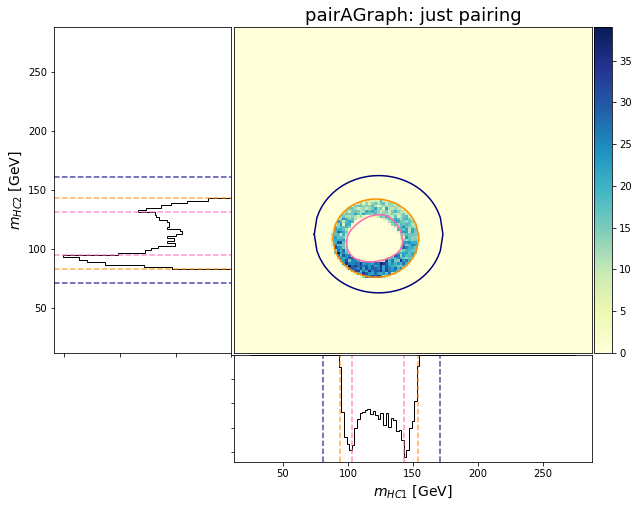

In [29]:
kwargs['save'] = False
fig = massplane(df.loc[(df.ntag>=4) & (df.kinematic_region == 1),'m_h1'],
                df.loc[(df.ntag>=4) & (df.kinematic_region == 1),'m_h2'],**kwargs)

In [30]:
fig = massplane(df.loc[(df.ntag>=4) & (df.kinematic_region == 2),'m_h1'],
                df.loc[(df.ntag>=4) & (df.kinematic_region == 2),'m_h2'],**kwargs)

In [31]:
prodTag = subDir.split('-')[1]

dataText = "$\mathbf{ATLAS}$ 2016 data\n"
dataText += f"{prodTag} prod with 2016 triggers\n"
dataText += "4 jets with $p_T$ > 40 GeV, $|\eta| < 2.5$, 2 b-tags"

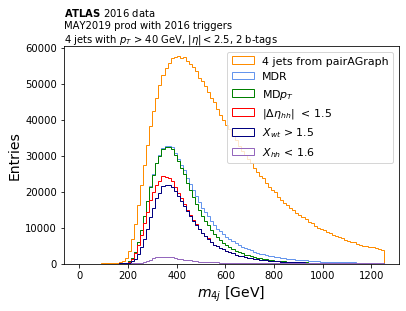

In [32]:
density=False

plt.hist(df.loc[df.ntag==2,'m_hh'],100,(0,1250),histtype='step',label='4 jets from pairAGraph',
         color='darkorange',density=density)
plt.hist(df.loc[(df.ntag==2)&(df.MDR),'m_hh'],100,(0,1250),histtype='step',label='MDR',
         color='cornflowerblue',density=density)
plt.hist(df.loc[(df.ntag==2)&df.MDpT,'m_hh'],100,(0,1250),histtype='step',label='MD$p_T$',
         color='green',density=density)
plt.hist(df.loc[(df.ntag==2)&df.cut_deta_hh,'m_hh'],100,(0,1250),histtype='step',label='$|\Delta \eta_{hh}|$  < 1.5',
         color='red',density=density)
plt.hist(df.loc[(df.ntag==2)&df.cut_Xwt,'m_hh'],100,(0,1250),histtype='step',label='$X_{wt}$ > 1.5',
         color='navy',density=density)
plt.hist(df.loc[(df.ntag==2)&df.cut_Xwt & (df.kinematic_region==0),'m_hh'],100,(0,1250),histtype='step',label='$X_{hh}$ < 1.6',
         color='C4',density=density)

plt.xlabel('$m_{4j}$ [GeV]',fontsize=14)
plt.ylabel('Entries',fontsize=14)
plt.legend(fontsize=11)

ax = plt.gca()
plt.text(0,1,dataText,ha='left',va='bottom',transform=ax.transAxes)

plt.savefig(f'{figDir}/m4j_allCuts.pdf',bbox_inches='tight')

plt.show()



Maybe I should also look at the 3b and 4b backgrounds?

Ok, this is *aweseome* and super interesting!

Let's look at the massplane again after all of the cuts are applied!

In [33]:
kwargs['title'] = 'pairAGraph: full analysis selction'
kwargs['bins'] = (50, 50)
kwargs['xrange'] = (25, 175)
kwargs['yrange'] = (25, 175)
kwargs['filename'] = f'{figDir}/massplane_allCuts_2b.pdf'
kwargs['save'] = True

fig = massplane(df.loc[(df.ntag==2)&(df.cut_Xwt),'m_h1'],
                df.loc[(df.ntag==2)&(df.cut_Xwt),'m_h2'],
                **kwargs)

fig.show()

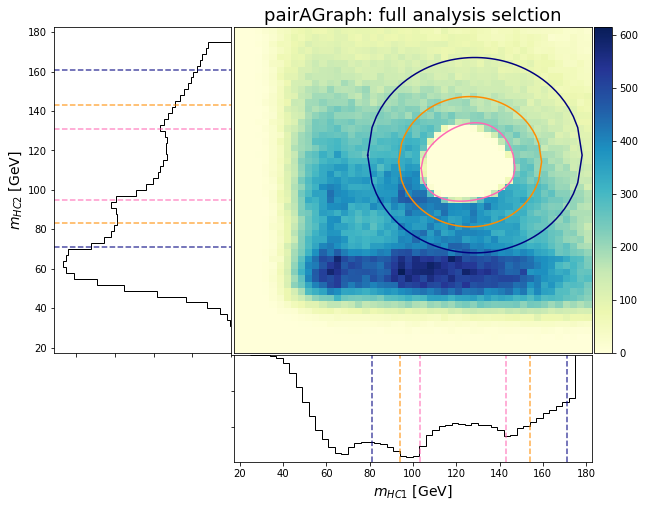

In [34]:
kwargs['filename'] = f'{figDir}/massplane_allCuts_3b.pdf'

fig = massplane(df.loc[(df.ntag==3)&(df.cut_Xwt)&(df.kinematic_region!=0),'m_h1'],
                df.loc[(df.ntag==3)&(df.cut_Xwt)&(df.kinematic_region!=0),'m_h2'],
                **kwargs)

fig.show()

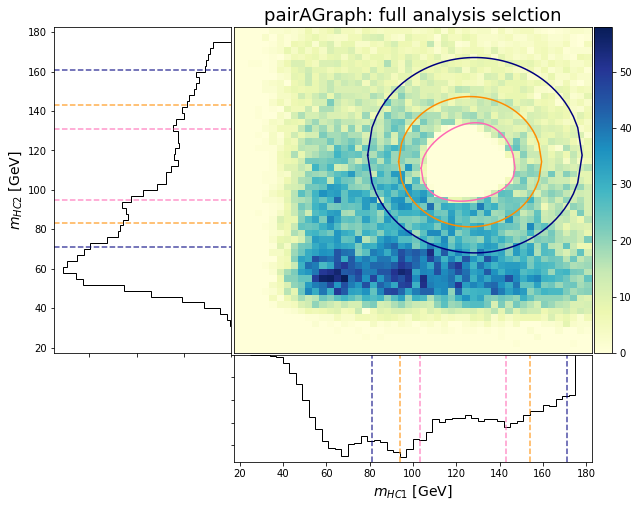

In [35]:
kwargs['filename'] = f'{figDir}/massplane_allCuts_4b.pdf'

fig = massplane(df.loc[(df.ntag>=4)&(df.cut_Xwt)&(df.kinematic_region!=0),'m_h1'],
                df.loc[(df.ntag>=4)&(df.cut_Xwt)&(df.kinematic_region!=0),'m_h2'],
                **kwargs)

fig.show()

Ok, we've seen these stripes form the $X_{wt}$ cut before, I'll probably need to derive the background estimate *before* $X_{wt}$ and then apply it after $X_{wt}$.

**Look at the same plot *before* $X_{wt}$**

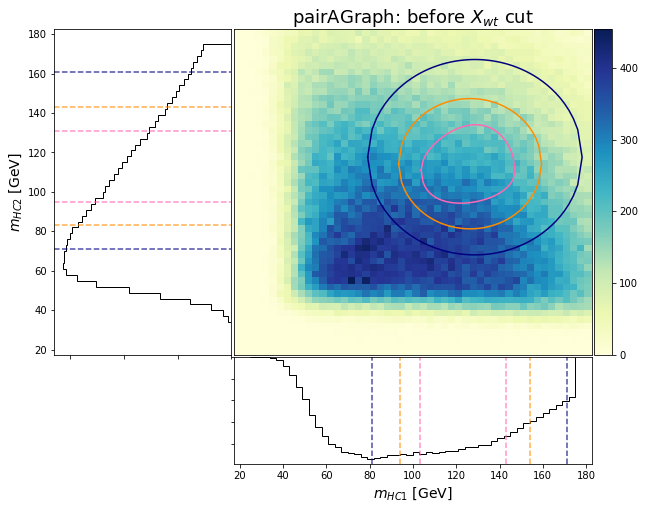

In [36]:
kwargs['title'] = 'pairAGraph: before $X_{wt}$ cut'
kwargs['filename'] = f'{figDir}/massplane_preXwt_2b.pdf'

fig = massplane(df.loc[(df.ntag==2)&(df.cut_deta_hh),'m_h1'],
                df.loc[(df.ntag==2)&(df.cut_deta_hh),'m_h2'],
                **kwargs)

fig.show()

In [37]:
print('\n2b:')
for k in [0,1,2]:
    print("  ",k,np.sum((df.ntag==2)&(df.cut_deta_hh)&(df.kinematic_region==k)))
    
print('\n3b:')
for k in [1,2]:
    print("  ",k,np.sum((df.ntag==3)&(df.cut_deta_hh)&(df.kinematic_region==k)))
    
print('\n4b:')
for k in [1,2]:
    print("  ",k,np.sum((df.ntag>=4)&(df.cut_deta_hh)&(df.kinematic_region==k)))


2b:
   0 30952
   1 44992
   2 78469

3b:
   1 60885
   2 107115

4b:
   1 4098
   2 7390


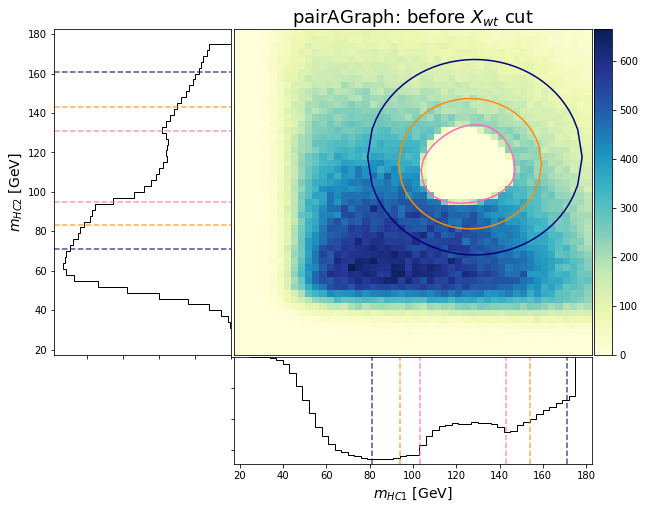

In [38]:
kwargs['filename'] = f'{figDir}/massplane_preXwt_3b.pdf'

fig = massplane(df.loc[(df.ntag==3)&(df.cut_deta_hh)&(df.kinematic_region!=0),'m_h1'],
                df.loc[(df.ntag==3)&(df.cut_deta_hh)&(df.kinematic_region!=0),'m_h2'],
                **kwargs)

fig.show()

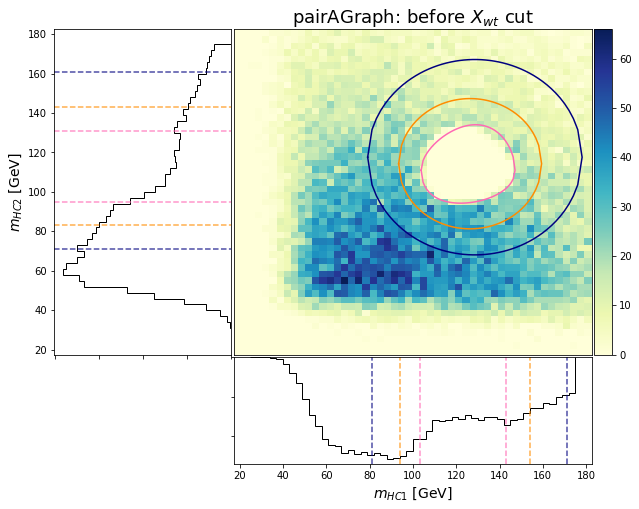

In [39]:
kwargs['filename'] = f'{figDir}/massplane_preXwt_4b.pdf'

fig = massplane(df.loc[(df.ntag>=4)&(df.cut_deta_hh)&(df.kinematic_region!=0),'m_h1'],
                df.loc[(df.ntag>=4)&(df.cut_deta_hh)&(df.kinematic_region!=0),'m_h2'],
                **kwargs)

fig.show()

**Finally:** Look at the massplane *only applying* the $|\Delta \eta_{hh}|$ < 1.5 cut.

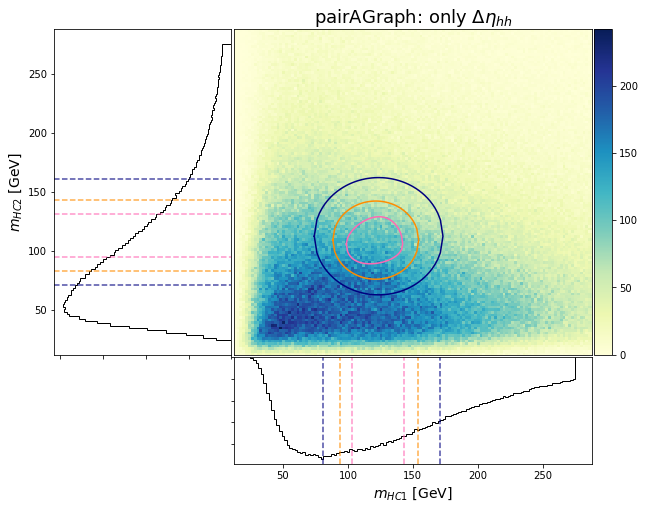

In [16]:
kwargs['title'] = 'pairAGraph: only $\Delta \eta_{hh}$'
kwargs['filename'] = f'{figDir}/massplane_deta_hh_2b.pdf'

fig = massplane(df.loc[(df.ntag==2)&(df.deta_hh < 1.5),'m_h1'],
                df.loc[(df.ntag==2)&(df.deta_hh < 1.5),'m_h2'],
                **kwargs)

fig.show()

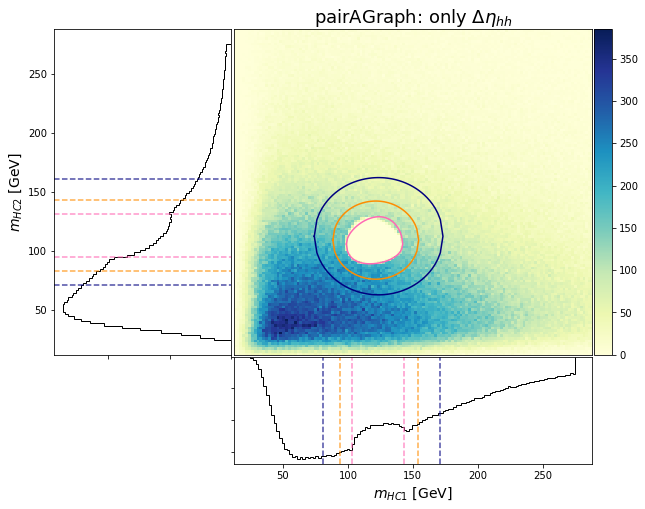

In [17]:
kwargs['filename'] = f'{figDir}/massplane_deta_hh_3b.pdf'

fig = massplane(df.loc[(df.ntag==3)&(df.deta_hh < 1.5)&(df.kinematic_region!=0),'m_h1'],
                df.loc[(df.ntag==3)&(df.deta_hh < 1.5)&(df.kinematic_region!=0),'m_h2'],
                **kwargs)

fig.show()

In [ ]:
kwargs['filename'] = f'{figDir}/massplane_deta_hh_4b.pdf'

fig = massplane(df.loc[(df.ntag>=4)&(df.deta_hh < 1.5)&(df.kinematic_region!=0),'m_h1'],
                df.loc[(df.ntag>=4)&(df.deta_hh < 1.5)&(df.kinematic_region!=0),'m_h2'],
                **kwargs)

fig.show()

**Next:** Michael wanted me to do some R&D to quantify this massplane a little better such as
- Making a contour plot instead
- Looking at the conditionals $P(m_1 | m_2)$
- I wanted to look at PCA to see if I could quanitfy ...

In [40]:
kwargs

{'figsize': (10, 8),
 'bins': (50, 50),
 'xrange': (25, 175),
 'yrange': (25, 175),
 'xhisttype': 'step',
 'yhisttype': 'step',
 'cmap': 'YlGnBu',
 'title': 'pairAGraph: before $X_{wt}$ cut',
 'xlabel': '$m_{HC1}$ [GeV]',
 'ylabel': '$m_{HC2}$ [GeV]',
 'axis_hist_on': True,
 'hist_color': 'black',
 'filename': 'figures/data_16_PFlow-MAY2019-5jets/xformer_train_SMNR_mc16ade//massplane_preXwt_4b.pdf',
 'alpha': 0.7,
 'save': True,
 'show': True}

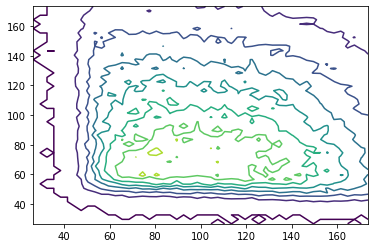

In [41]:
n,xx,yy = np.histogram2d(df.loc[(df.ntag==2)&(df.cut_deta_hh),'m_h1'],
                         df.loc[(df.ntag==2)&(df.cut_deta_hh),'m_h2'],
                         kwargs['bins'],[kwargs['xrange'],kwargs['yrange']])

xx = 0.5 * (xx[:-1]+xx[1:])
yy = 0.5 * (yy[:-1]+yy[1:])

x,y = np.meshgrid(xx,yy)
plt.contour(x,y,n.T)

# Add a color bar, overlay the SR?


plt.show()

Next - let's look at the conditionals.

What I wanted to try: PCA for dimensionality reduction!

In [42]:
X = np.vstack((df.loc[(df.ntag==2)&(df.cut_deta_hh),'m_h1'],
               df.loc[(df.ntag==2)&(df.cut_deta_hh),'m_h2'])).T
X.shape

(439737, 2)

In [43]:
from sklearn.decomposition import PCA

The tutorial that I was following for the syntax: [link](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)

In [44]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)

print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (439737, 2)
transformed shape: (439737, 1)


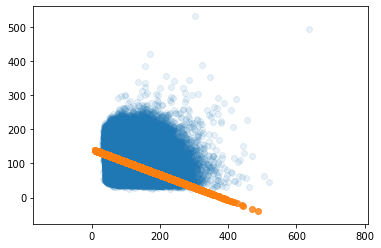

In [45]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.1)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

Hmmmmm, this is counter intuitive to me, I would have thought the PCA vector would have been pointing in the other direction.

In [46]:

n,xx,yy,_ = plt.hist2d()

TypeError: hist2d() missing 2 required positional arguments: 'x' and 'y'

In [ ]:
df.columns

## 2. Sculpting comparison between 2b and 4b

Ok, so since for min $\Delta R_{jj}^{HC1}$, I didn't see any improvement with the smoother massplane in terms of the limit with the background systematics.

One hypothesis for why this might be was b/c maybe we don't care about the massplane being smooth, 

way that the current systematic was impacting the  



In [ ]:
kwargs

In [ ]:
options = kwargs

n2b,xx,yy = np.histogram2d(df.loc[(df.ntag==2)&(df.kinematic_region!=0),'m_h1'], 
                           df.loc[(df.ntag==2)&(df.kinematic_region!=0),'m_h2'], 
                           bins = options['bins'], range=(options['xrange'], options['yrange']))
#, weights = options['weights'])#, cmap = options['cmap'])

n4b,xx,yy = np.histogram2d(df.loc[(df.ntag>=4)&(df.kinematic_region!=0),'m_h1'], 
                           df.loc[(df.ntag>=4)&(df.kinematic_region!=0),'m_h2'], 
                           bins = options['bins'], range=(options['xrange'], options['yrange']))
#, weights = options['weights'], cmap = options['cmap'])

fig, ax = plt.subplots(1,1)

n = n4b/n2b
pcm = ax.pcolormesh(xx,yy,np.log(n.T))
fig.colorbar(pcm, ax=ax)

plt.xlabel('$m_{HC1}$ [GeV]',fontsize=14)
plt.ylabel('$m_{HC2}$ [GeV]',fontsize=14)

# Overlay the SR, VR, CR lines
plt.title('pairAGraph after pairing: $n_{4b}/n_{2b}$')

plt.show()

In [ ]:
?ax.pcolormesh

Ok, but what I *ultimately* want to do is contrast with the baseline and min $\Delta R_{jj}^{HC1}$, so compare and contrast these plots with the baseline and min $\Delta R_{jj}^{HC1}$ plots

In [ ]:
# Note: this is a topo file!!
filename = "../../public/hh4b/nanoNtuples/data16/data16_with_weights.root"
tree = uproot.open(filename)["fullmassplane"]
minDhh = tree.pandas.df()

In [ ]:
minDhh.columns

For the baseline, we reweight after $X_{wt}$.

In [ ]:
n2b,xx,yy = np.histogram2d(minDhh.loc[(minDhh.ntag==2)&(minDhh.kinematic_region!=0),'m_h1'], 
                           minDhh.loc[(minDhh.ntag==2)&(minDhh.kinematic_region!=0),'m_h2'], 
                           bins = 50, range=(options['xrange'], options['yrange']))
#, weights = options['weights'])#, cmap = options['cmap'])

n4b,xx,yy = np.histogram2d(minDhh.loc[(minDhh.ntag>=4)&(minDhh.kinematic_region!=0),'m_h1'], 
                           minDhh.loc[(minDhh.ntag>=4)&(minDhh.kinematic_region!=0),'m_h2'], 
                           bins = 50, range=(options['xrange'], options['yrange']))

fig, ax = plt.subplots(1,1)

n = n4b/n2b
pcm = ax.pcolormesh(xx,yy,n.T)
fig.colorbar(pcm, ax=ax)

plt.xlabel('$m_{HC1}$ [GeV]',fontsize=14)
plt.ylabel('$m_{HC2}$ [GeV]',fontsize=14)

# Overlay the SR, VR, CR lines


plt.title('baseline after $X_{wt}$: $n_{4b}/n_{2b}$')

plt.show()

Ok, this is honestly pretty encouraging (I think), but I will probably want to play with the color maps more just to make sure that I understand what is going on here!

**min dR**

In [ ]:
newfileName = "../../hh4b-resolved-reconstruction/{}_topo16_min_Rjj_h1_vec.root"

# hadtop = pd.DataFrame(root2array(newfileName.format("data16"),"hadtop"))
# multijet = pd.DataFrame(root2array(newfileName.format("data16"),"top_multijet"))

f = uproot.open(newfileName.format("data16"))
hadtop = f["hadtop"].pandas.df()
multijet = f["top_multijet"].pandas.df()

mindR = pd.concat([hadtop, multijet],ignore_index=True)

In [ ]:
n2b,xx,yy = np.histogram2d(mindR.loc[(mindR.ntag==2)&(mindR.kinematic_region!=0),'m_h1'], 
                           mindR.loc[(mindR.ntag==2)&(mindR.kinematic_region!=0),'m_h2'], 
                           bins = 50, range=(options['xrange'], options['yrange']))
#, weights = options['weights'])#, cmap = options['cmap'])

n4b,xx,yy = np.histogram2d(mindR.loc[(minDhh.ntag>=4)&(mindR.kinematic_region!=0),'m_h1'], 
                           mindR.loc[(minDhh.ntag>=4)&(mindR.kinematic_region!=0),'m_h2'], 
                           bins = 50, range=(options['xrange'], options['yrange']))

fig, ax = plt.subplots(1,1)

n = n4b/n2b
pcm = ax.pcolormesh(xx,yy,np.log(n.T))
fig.colorbar(pcm, ax=ax)

plt.xlabel('$m_{HC1}$ [GeV]',fontsize=14)
plt.ylabel('$m_{HC2}$ [GeV]',fontsize=14)

# Overlay the SR, VR, CR lines


plt.title('min $\Delta R_{jj}^{HC1}$ before $X_{wt}$: $n_{4b}/n_{2b}$')

plt.show()

Next, compare with min $\Delta R_{jj}^{HC1}$.

## 3. Cutflows

Ok, this is pretty encouraging, the only thing I'm conerned about actually when looking @ these plots is whether or not I have the HCs in the correct order.

## 4. Background estimate

I think it would be really nice to use Sean's new NN for the [background reweighting](https://gitlab.cern.ch/hh4b/hh4b-background-estimation/blob/nn-reweighting/Resolved/NN_RW.py) script.

- It uses the same variables as the prev iteration of the analysis, except it also uses $p_T^{hh}$
- Before ... he takes the log of ...
- Are all the variables normalized?
- 

**Plan:** I'm just going to cut-and-copy code over from Rafael's nb.

### 3.1 Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
np.mean(df_3b.nbtags==4)

In [ ]:
# class rwDataset():
    
#     def __init__(self, df_2b, df_3b):        
#         '''
#         Goal: Load in the jet level variables into a pytorch dataframe to be ready
#         for training, and do the necessary ml pre-processing.
#         '''
        
#         rw_columns = ['njets','eta_i','pT_2','pT_4','dRjj_1','dRjj_2','pt_hh']
        
#         # We reweight in the SB at the end of the analysis
#         original = df_2b.loc[df_2b.cut_Xwt & df_2b.SB,rw_columns]
#         target   = df_3b.loc[df_3b.cut_Xwt & df_3b.SB & (df_3b.nbtags>=4),rw_columns]
        
#         X = pd.concat((original, target), ignore_index=True).values
#         X[:,2:] = np.log(X[:,2:])
        
#         y = []
#         for _df, ID in [(original,1), (target, 0)]:
#             y.extend([ID] * _df.shape[0])
#         y = np.array(y)

#         scaler = StandardScaler()
#         X_scaled = scaler.fit_transform(X)

#         self.X = torch.from_numpy(X_scaled).float()
#         self.y = torch.from_numpy(y).float()
        
#         # Save the scaling file for evaluation (later)
#         d = {}
#         d['mean'] = list(scaler.mean_)
#         d['scale'] = list(scaler.scale_)
#         d['var'] = list(scaler.var_)
#         d['n_samples_seen'] = int(scaler.n_samples_seen_)

#         with open('rw_scale.json', 'w') as varfile:
#             json.dump(d, varfile)
        
        
#     def __len__(self):
#         return self.X.shape[0] 

#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]


**To do for later:** I should really combine these two functions rwDataset and getDataLoaders into a single function that also makes some basic preprocessing plots.

In [ ]:
loader_train, loader_val = getDataLoaders()

Let's look at the plots!!

### 3.2 Model definition

**Plan:** I'm going to implement this in pytorch instead of keras!!


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class reweighter(nn.Module):

    def __init__(self,inpt_dim=7,hidden_dim=20,nLayers=3):
        '''
        Inputs:
        - inpt_dim: The number of features used for the reweighting
            Default 7 for njets, pT_2, pT_4, eta_i, dRjj_1, dRjj_2, pt_hh
        - hidden_dim: The dimension for the hidden layers
        '''

        super(reweighter, self).__init__()

        self.h1  = nn.Linear(inpt_dim,  hidden_dim)
        self.h2  = nn.Linear(hidden_dim,hidden_dim)
        self.h3  = nn.Linear(hidden_dim,hidden_dim)
        self.out = nn.Linear(hidden_dim,1)

    def forward(self, x):
    
        h = self.h1(x)
        
        for linear in [self.h2,self.h3,self.out]:
            h = nn.ReLU()(h)
            h = linear(h)
            
        return h
        

In [ ]:
rw = reweighter()
#rw.to(device)

### 3.3 Model training

The loss that Sean was using is defined below, and he was using the adam optimizer,  training for a maximum of 50 epochs w/ early stopping.


In [ ]:
def louppe_loss(y_true, y_pred):
    return torch.mean(y_true * (torch.sqrt(torch.exp(y_pred))) + 
            (1.0 - y_true) * (1.0 / torch.sqrt(torch.exp(y_pred))))


In [ ]:
optimizer = torch.optim.Adam(rw.parameters(), lr=.001)

nEpochs = 50

# keys = ["_".join([s,m]) for s in ['train','val'] for m in ['loss','acc','acc_3b','acc_4b']]
# metrics = {k:[] for k in keys}

device = 'cuda:9' if torch.cuda.is_available() else 'cpu'
rw.to(device=device)

for epoch in range(nEpochs):

    L = 0
    rw.train()

    for xi,yi in loader_train:

        xi = xi.to(device=device)
        yi = yi.to(device=device)

        optimizer.zero_grad()

        pred = rw(xi)
        loss = louppe_loss(yi, pred)
                
        loss.backward()
        optimizer.step()

        L += loss.item()

    print(L)

Plot the training metrics

In [ ]:
def getWeights(rw):
    '''
    Goal: Given the NN reweighting model, get the associated weights
    to get from the 2b dataset to the anticipated 4b dists
    '''

    rw_columns = ['njets','eta_i','pT_2','pT_4','dRjj_1','dRjj_2','pt_hh']
    X = df_2b[rw_columns].values
    X[:,2:] = np.log(X[:,2:])

    with open("rw_scale.json", 'r') as varfile:
        varinfo = json.load(varfile)

    scaler        = StandardScaler(copy=False) # scale the data in place
    scaler.mean_  = varinfo['mean']
    scaler.scale_ = varinfo['scale'] 
    scaler.var_   = varinfo['var'] 
    scaler.n_samples_seen_ = varinfo['n_samples_seen'] 
    scaler.transform(X)

    Xpt = torch.tensor(X).float().to(device)

    rw.eval()
    R = torch.exp(rw(Xpt)).cpu().detach().numpy()

    plt.hist(R)
    plt.xlabel('R(x)')
    plt.show()
    
    N_2b = np.sum((df_2b.cut_Xwt)&df_2b.SB)
    N_4b = np.sum((df_3b.nbtags>=4)&(df_3b.cut_Xwt)&df_3b.SB)

    df_2b['w_2b'] = R #* N_4b / N_2b
    
getWeights(rw)

### 3.4 Evaluation

Compare the output distributions on the reweighting variables.

In [ ]:
np.sum(SB_4b&(df_3b.njets==4)),np.sum(SB_4b&(df_3b.njets==5))

In [ ]:
SB_2b = (df_2b.cut_Xwt) & df_2b.SB
SB_4b = (df_3b.nbtags>=4)&(df_3b.cut_Xwt)&df_3b.SB

for c,b,r in zip(['njets','pT_4','pT_2','eta_i','dRjj_1','dRjj_2','pt_hh'],
                 [8]+[20]*6,
                 [(2.5,10.5),(0,125),(0,200),(0,2.5),(0,np.pi),(0,np.pi),[0,600]]):
    plt.figure()
    plt.hist(df_2b.loc[SB_2b,c],b,r,histtype='step',
             weights=df_2b.loc[SB_2b,'w_2b'],label='2b')
    plt.hist(df_3b.loc[SB_4b,c],b,r,histtype='step',label='4b')
    plt.legend()
    plt.xlabel(c)
plt.show()

This looks reasonable, but I'm still not sure about the normalization.

**I'll ask Sean or Rafael tomorrow!**

## 4. Analysis Categorization

## 5. Stats only limits